#### Set experiment parameters in config
For training that terminates in a reasonable timeframe use data in sample_subset/audio.
This is not a real dataset as it consists of 10 images, but the functionality of the code can be examined.
The full dataset can be found here "https://magenta.withgoogle.com/datasets/nsynth#files" It must first be extracted, for example with the function in data_work.ipynb. To use the full dataset, preprocessing is recommend. A function for this purpose can also be found in the data_work notebook. To continue with the experiment, set the parameters of the config to something reasonable for your hardware like done bewlow:

In [1]:
from config import load_config
config = load_config()
#Set folder to sample dataset for prototypin
#config.data.train_audio_folder = 'data/sample_subset/audio'
#config.data.test_audio_folder = 'data/sample_subset/audio'
config.vae.batch_size = 256
config.vae.epochs = 50

In [ ]:
from train_vae import train, test, simple_kl_annealing
from datasets import HDF5SpectrogramDataset, collate_fn, SpectogramDataset
from VAE_models import VAE, CVAE, count_parameters, save_checkpoint

from datetime import datetime
import os

from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision.transforms import v2
import torch

conv = True

# Define image transformation if wanted for regularization
transforms = v2.Compose([
    v2.RandomResizedCrop(size=(128, 172), antialias=True),
    v2.RandomHorizontalFlip(p=0.5)
    ])


train_data = HDF5SpectrogramDataset('data/train_spectrograms_even.h5', transform=transforms)
test_data = HDF5SpectrogramDataset('data/valid_spectrograms_even.h5')

train_loader = DataLoader(train_data, batch_size=config.vae.batch_size, shuffle=True, pin_memory=True, num_workers=8, persistent_workers=True, prefetch_factor=2)
test_loader = DataLoader(test_data, batch_size=config.vae.batch_size, shuffle=False, pin_memory=True, num_workers=4, persistent_workers=True)

sample_spec = train_data[0] # Sample spectogram 
in_dim = sample_spec.numel() # For spectograms = width * height
image_size = tuple(sample_spec.size())

timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = os.path.join(config.log_dir, timestamp)
os.makedirs(log_dir, exist_ok=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
print(device)

if conv:
    model = CVAE([128, 172], config.vae.latent_dim, 0.0).to(device)
else:
    model = VAE(in_dim, config.vae.latent_dim, config.vae.n_layers, config.vae.beta_kl).to(device)

print(count_parameters(model))

torch.set_float32_matmul_precision("medium")
#model = torch.compile(model, mode="max-autotune")

optimizer = torch.optim.Adam(model.parameters(), lr=config.vae.lr, weight_decay=config.vae.weight_decay)
writer = SummaryWriter(log_dir)
prev_updates = 0
best_loss = torch.tensor(float('Inf'))
for epoch in range(config.vae.epochs):
    print(f'Epoch {epoch+1}/{config.vae.epochs}')
    beta = simple_kl_annealing(epoch)
    print(f'using beta: {beta}')
    model.set_beta(beta)
    prev_updates = train(model, train_loader, optimizer, prev_updates, config, device=device, writer=writer, conv=conv)
    _, _, test_kl_loss = test(model, test_loader, prev_updates, config, device, writer=writer, conv=True)
    if test_kl_loss < best_loss:
        best_loss = test_kl_loss
        if conv:
            save_checkpoint(model, optimizer, epoch, test_kl_loss, config, conv, image_size)
        else:
            save_checkpoint(model, optimizer, epoch, test_kl_loss, config, conv, in_dim)
    


cuda
8881153
Epoch 1/50
using beta: 0.009999999776482582


  0%|          | 4/1130 [00:02<08:47,  2.13it/s]

Step 0 (N samples: 0), Loss: 2844.0327 (Recon: 2844.0327, KL: 0.0001) Grad: inf


 45%|████▍     | 503/1130 [00:37<00:47, 13.34it/s]

Step 500 (N samples: 128,000), Loss: 181.1503 (Recon: 178.1530, KL: 2.9972) Grad: 1904.1806


 89%|████████▊ | 1002/1130 [01:14<00:09, 13.00it/s]

Step 1,000 (N samples: 256,000), Loss: 164.4919 (Recon: 161.6007, KL: 2.8912) Grad: 1385.4027


Testing: 100%|██████████| 50/50 [00:03<00:00, 15.80it/s]


====> Test set loss: 247.8643 (BCE: 243.6991, KLD: 4.1651)
Epoch 2/50
using beta: 0.009999999776482582


 33%|███▎      | 374/1130 [00:26<00:51, 14.77it/s]

Step 1,500 (N samples: 384,000), Loss: 170.0574 (Recon: 166.6483, KL: 3.4091) Grad: 76822.7714


 77%|███████▋  | 872/1130 [01:01<00:16, 15.90it/s]

Step 2,000 (N samples: 512,000), Loss: 156.4741 (Recon: 153.4809, KL: 2.9931) Grad: 45569.8001


Testing: 100%|██████████| 50/50 [00:02<00:00, 19.66it/s]


====> Test set loss: 239.3166 (BCE: 235.0860, KLD: 4.2306)
Epoch 3/50
using beta: 0.009999999776482582


 22%|██▏       | 246/1130 [00:16<00:52, 16.73it/s]

Step 2,500 (N samples: 640,000), Loss: 11072.2500 (Recon: 8773.3721, KL: 2298.8782) Grad: nan


 66%|██████▌   | 744/1130 [00:50<00:22, 17.49it/s]

Step 3,000 (N samples: 768,000), Loss: 130.8424 (Recon: 127.1740, KL: 3.6684) Grad: 301.9208


Testing: 100%|██████████| 50/50 [00:01<00:00, 30.76it/s]


====> Test set loss: 198.8461 (BCE: 193.3411, KLD: 5.5050)
Epoch 4/50
using beta: 0.009999999776482582


 10%|█         | 114/1130 [00:07<00:57, 17.78it/s]

Step 3,500 (N samples: 896,000), Loss: 113.8215 (Recon: 108.9334, KL: 4.8881) Grad: 180428.3080


 54%|█████▍    | 611/1130 [00:42<00:33, 15.34it/s]

Step 4,000 (N samples: 1,024,000), Loss: 115.8586 (Recon: 110.5612, KL: 5.2974) Grad: 67732.5183


 98%|█████████▊| 1113/1130 [01:16<00:01, 14.04it/s]

Step 4,500 (N samples: 1,152,000), Loss: 136.0756 (Recon: 129.3681, KL: 6.7075) Grad: 50563.6819


Testing: 100%|██████████| 50/50 [00:02<00:00, 23.15it/s]


====> Test set loss: 207.7934 (BCE: 200.9166, KLD: 6.8768)
Epoch 5/50
using beta: 0.009999999776482582


 43%|████▎     | 481/1130 [00:31<00:36, 17.91it/s]

Step 5,000 (N samples: 1,280,000), Loss: 130.7289 (Recon: 124.7370, KL: 5.9919) Grad: 211742.2755


 87%|████████▋ | 984/1130 [01:05<00:08, 17.21it/s]

Step 5,500 (N samples: 1,408,000), Loss: 124.4555 (Recon: 118.7152, KL: 5.7403) Grad: 112813.5466


Testing: 100%|██████████| 50/50 [00:01<00:00, 30.27it/s]


====> Test set loss: 190.8514 (BCE: 184.5701, KLD: 6.2813)
Epoch 6/50
using beta: 0.02007855288684368


 31%|███       | 351/1130 [00:22<00:46, 16.79it/s]

Step 6,000 (N samples: 1,536,000), Loss: 114.8429 (Recon: 105.0410, KL: 9.8019) Grad: 120.2772


 76%|███████▌  | 854/1130 [00:53<00:19, 14.33it/s]

Step 6,500 (N samples: 1,664,000), Loss: 100.2208 (Recon: 92.7801, KL: 7.4407) Grad: 107.1968


Testing: 100%|██████████| 50/50 [00:01<00:00, 32.44it/s]


====> Test set loss: 197.3178 (BCE: 187.9445, KLD: 9.3733)
Epoch 7/50
using beta: 0.05395863205194473


 20%|█▉        | 223/1130 [00:13<00:47, 19.24it/s]

Step 7,000 (N samples: 1,792,000), Loss: 126.8623 (Recon: 110.7766, KL: 16.0857) Grad: 72547.9109


 64%|██████▎   | 720/1130 [00:43<00:20, 19.85it/s]

Step 7,500 (N samples: 1,920,000), Loss: 129.1457 (Recon: 114.8913, KL: 14.2544) Grad: 75288.5479


Testing: 100%|██████████| 50/50 [00:01<00:00, 31.21it/s]


====> Test set loss: 209.8645 (BCE: 194.2161, KLD: 15.6484)
Epoch 8/50
using beta: 0.14227762818336487


  5%|▍         | 56/1130 [00:03<01:14, 14.42it/s]


KeyboardInterrupt: 

#### Load model and decode random latent codes

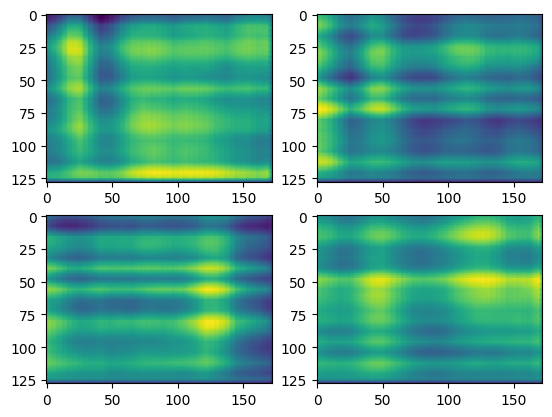

In [3]:
import matplotlib.pyplot as plt
import torch
from VAE_models import load_vae_model
conv = True
model, checkpoint = load_vae_model('models/conv_vae/c_vae_checkpoint_20250704-003759.pt', 'cuda', conv=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.eval()

z = torch.randn(4, checkpoint['config']['latent_dim']).to(device)
with torch.no_grad():
    samples = model.decode(z)
samples = samples.cpu().view(4, 128, 172).numpy()
plt.figure()
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.imshow(samples[i])

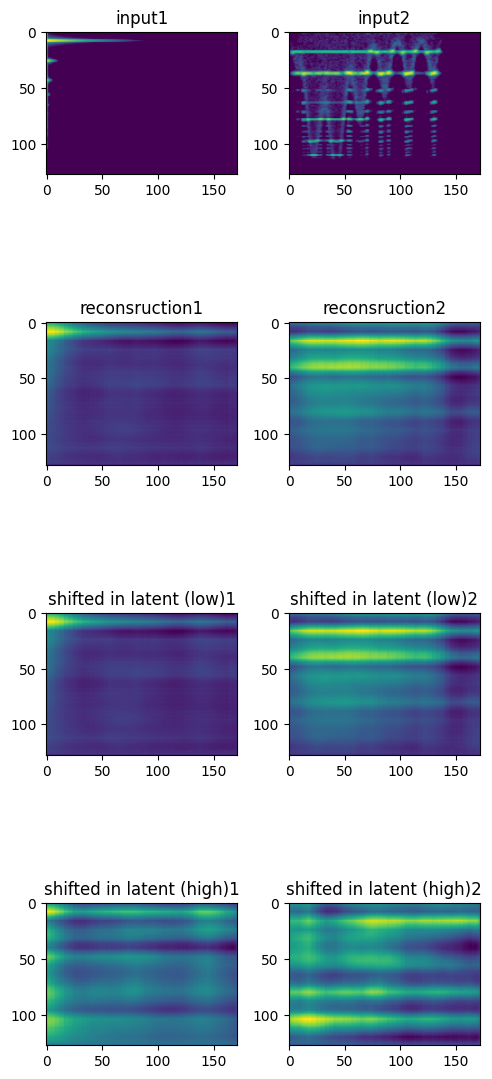

In [4]:
from datasets import HDF5SpectrogramDataset
from torch.utils.data import DataLoader
import numpy as np
num_samples = 2
train_data = HDF5SpectrogramDataset('data/train_spectrograms_even.h5')
train_loader = DataLoader(train_data, batch_size=num_samples, shuffle=True)

inputs = next(iter(train_loader))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
inputs = inputs.to(device)
with torch.no_grad():
    if not conv:
        inputs = inputs.view(num_samples, -1)  # Flatten the data when not using convolutional VAE
    else:
        inputs = inputs.view(num_samples, 1, 128, 172)
    dist = model.encode(inputs)
    z_s = model.reparameterize(dist)
    recons = model.decode(z_s).cpu().view(num_samples, 128, 172).numpy()
    shifted_z_s_high = z_s + torch.rand_like(z_s) * 5.0
    shifted_z_s_low = z_s + torch.rand_like(z_s) * 000.1
    shifted_high = model.decode(shifted_z_s_high).cpu().view(num_samples, 128, 172).numpy()
    shifted_low = model.decode(shifted_z_s_low).cpu().view(num_samples, 128, 172).numpy()
    inputs = inputs.cpu().view(num_samples, 128, 172).numpy()
images = np.array([inputs, recons, shifted_high, shifted_low]).reshape((8, 128, 172))
plt.figure(figsize=[5,12])
for i in range(num_samples):
    plt.subplot(4,num_samples,i+1)
    plt.imshow(inputs[i])
    plt.title(f'input{i+1}')
    plt.subplot(4,num_samples,i+num_samples+1)
    plt.imshow(recons[i])
    plt.title(f'reconsruction{i+1}')
    plt.subplot(4,num_samples,i+2*num_samples+1)
    plt.imshow(shifted_low[i])
    plt.title(f'shifted in latent (low){i+1}')
    plt.subplot(4,num_samples,i+3*num_samples+1)
    plt.imshow(shifted_high[i])
    plt.title(f'shifted in latent (high){i+1}')
plt.tight_layout()

